##### Importamos las librerías necesarias

In [14]:
import hashlib as hl
import numpy as np
import math as mth
## esta nos servirá después
import pandas as pd
import random as rnd

##### Nuestra implementación de bloom filter

In [25]:
class BloomFilter():
  def __init__(self, m=10, k=1):
    # en realidad estas tres líneas de código son una "funcion"
    # de cuantos veces haremos la llamada a md5 y cuantos cachos tomamos de el
    self.bits = mth.ceil(mth.log(m,2))
    #cuantos cachos de caracteres voy a tomar del objeto 
    self.caracteres_hexa = mth.ceil(self.bits/4) 
    # cuantos procesos voy a hacer, dividimos entre 32
    # porque ese es el tamaño de hl.md5().hexdigest()
    # la complejidad de insertar: O(procesosMD5) en realidad es O(k)
    self.procesosMD5 = mth.ceil(k*self.caracteres_hexa/32)
    self.m = m
    self.k = k
    self.bloom = np.zeros(m, dtype = bool)

  def calculaKposiciones(self, objeto: str):
    # Regresa k posiciones para poner en True en el bloom
    posiciones = []
    hash = ''

    # al hacer este for estoy repitiendo mi string
    # digamos que mi resultado de hl.md5(cadena2.encode('utf-8')).hexdigest()
    # es: 1983adf (no es real porque en realidad es de tamaño 32)
    # despues de esto mi hash seria 1983adf1983adf...1983adf
    for procesos in range(self.procesosMD5):
      cadena2 = objeto +str(procesos)
      # la funcion hl.md5() necesita recibir el string encoded
      # luego regresa un objeto al que podemso aplicar hexdigest
      hexa = hl.md5(cadena2.encode('utf-8')).hexdigest()
      hash += hexa


    ## k * caracteres_hexa me dice cuantos caracteres voy a tomar
    ## la manera en la que iteramos es sobre bloques caracteres_hexa
    ## hace sentido porque k * caracteres_hexa/caracteres_hexa = k
    for i in range(0, self.k*self.caracteres_hexa, self.caracteres_hexa):
      # int(hexa, 16) tiene que tener modulo m para que quepa en el arreglo
      valor = int(hash[i:i + self.caracteres_hexa], 16) % self.m
      posiciones.append(valor)


    return posiciones

  def inserta(self, objeto: str):
    posiciones = self.calculaKposiciones(objeto)

    for pos in posiciones:
      self.bloom[pos] = True

  def busca(self, objeto: str):
    posiciones = self.calculaKposiciones(objeto)
    i = 0
    found = True
    while i < len(posiciones) and found:
      found = self.bloom[posiciones[i]]
      i +=1

    return found


#### No hemos trabajado con bloom filters así que hagamos un ejercicio primero

In [15]:
def generaStrAzar(n):
  res=''
  for i in range(n):
    res+=chr(rnd.randint(65,91))
  return res

In [22]:
datos = [generaStrAzar(5) for i in range(20)]
mitad = int(len(datos)/2)
particion1 = datos[:mitad]
particion2 = datos[mitad:]
## revisamos que en efecto sean particiones
for elem in particion1: 
    if elem in particion2: 
        print("no es particion")

#### vamos a insertar la particion1 solamente y luego vamos a preguntar si los datos de particion2 están en el bloom filter

In [73]:
yaloencontre = False
for m in range(30, 400):
    limite = int(m/2 + 1)
    for k in range(1, limite):
        bloom = BloomFilter(m, k)
        for elem in particion1: 
            bloom.inserta(elem)
            
        fpcount = 0
        for elem in particion2:
            if bloom.busca(elem):
                fpcount+=1
    
        if fpcount/len(particion2) <= .1:
            print(f"Encontre los valores de m y k y son {m} {k}, {fpcount/len(particion2)}, {fpcount}")
            yaloencontre = True

    if yaloencontre:
        break
            



Encontre los valores de m y k y son 31 3, 0.1, 1


In [72]:
bloom = BloomFilter(m=30, k=8)

## insertar los datos
for elem in particion1: 
    bloom.inserta(elem)

## preguntar por los datos que no metimos
fpcount = 0
for elem in particion2:
    if bloom.busca(elem):
        print(f"Encontre un bug con el elemento {elem}")
        fpcount += 1

print(f'al final tuve {fpcount} falsos positivos')
print(f'Mi porcentaje de falsos positivos es: {fpcount/len(particion2)}')

Encontre un bug con el elemento SVDZI
Encontre un bug con el elemento TQGNX
Encontre un bug con el elemento IKSVW
Encontre un bug con el elemento AU[AE
Encontre un bug con el elemento CBPKD
Encontre un bug con el elemento BWMNA
Encontre un bug con el elemento AGSQN
Encontre un bug con el elemento HLFUI
al final tuve 8 falsos positivos
Mi porcentaje de falsos positivos es: 0.8


#### Ahora sí usemos los datos para el experimento

In [1]:
df = pd.read_csv("malicious_phish.csv")

df['malicious'] = df['type'].apply(lambda x: 1 if x!= 'benign' else 0)


In [2]:
df.head(5)

,url,type,malicious
0,br-icloud.com.br,phishing,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [3]:
datos_insertar = df[df['malicious'] == 1]

In [4]:
datos_revisar = df[df['malicious'] == 0]

In [5]:
datos_insertar.to_csv("insercionBF.csv", index=False)
datos_revisar.to_csv("revisarBF.csv", index=False)

In [7]:
datos_revisar.size

1284309

In [8]:
datos_insertar.size

669264

In [11]:
## Iterar sobre los elementos de un dataframe, para poder insertarlos al bloom

for idx, elem in enumerate(datos_insertar['url']):
    if idx > 7: 
        break
    print(idx, elem)

0 br-icloud.com.br
1 http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15
2 http://adventure-nicaragua.net/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZS1uaWNhcmFndWEubmV0L2luZGV4LnBocD9vcHRpb249Y29tX2NvbnRlbnQmdmlldz1hcnRpY2xlJmlkPTQ3OmFib3V0JmNhdGlkPTM2OmRlbW8tYXJ0aWNsZXMmSXRlbWlkPTU0
3 http://www.pashminaonline.com/pure-pashminas
4 http://www.ikenmijnkunst.nl/index.php/exposities/exposities-2006
5 http://www.lebensmittel-ueberwachung.de/index.php/aktuelles.1
6 http://www.szabadmunkaero.hu/cimoldal.html?start=12
7 http://larcadelcarnevale.com/catalogo/palloncini


In [ ]:
## iterar sobre los elementos del dataframe, para revisar si están o no
# sabemos por fact que ninguno de estos están en el bloom

for idx, elem in enumerate(datos_revisar['url']):
    if idx > 5: 
        break

    print(elem)

#### Una opción que les propongo para graficar: 

##### Para hacer esta opción tienen que guardar sus datos en un dataframe o un diccionario de manera que tengan una columna que sea m otra que sea k y otra que sea fp (%falsos positivos) para esos valores de m y k

In [ ]:
! pip install rpy2
%load_ext rpy2.ipython

In [64]:
dataejemplo = pd.DataFrame({"k": [i for i in range(1, 5)]+[i for i in range(1, 5)], "m": [i*10 for i in range(1, 5)] + [i*14 for i in range(1, 5)], "fp": [1/i for i in range(1, 5)] + [1/(i+1) for i in range(1, 5)]})
dataejemplo.to_csv("datosconFP.csv", index=False)

#### Con esta opción pueden ver "3 variables" los fp y como cambian con respecto a m para una k fija. La k fija es la que se ve como "subtítulo en la gráfica". NOTA: si hacen el experimento con muchas k's esta matriz de gráficas se vería muy fea

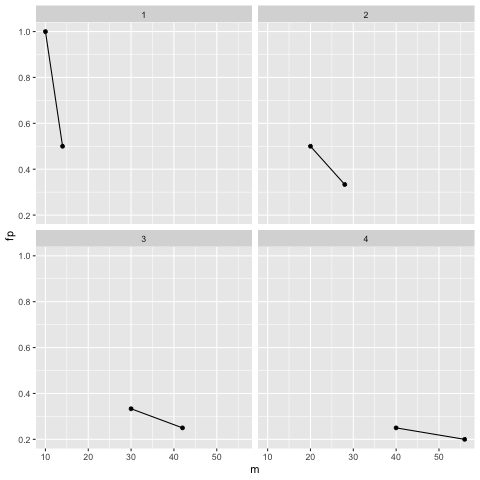

In [65]:
%%R
library(ggplot2)
data <- read.csv("datosconFP.csv")
g <- ggplot(data, aes(x=m, y = fp)) + geom_line() + geom_point() + facet_wrap(~k)
g